<a href="https://colab.research.google.com/github/lucagnecchi/Image_classification/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Filippo Elmino 5208413
- Luca Gnecchi 5206807

# Import libraries

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
!pip install torch torchvision
!pip install d2l==1.0.0a1.post0
import torch
from torchvision import transforms, datasets
from torch.utils import data
import torch.nn.functional as F
from torch.utils.data import ConcatDataset
from d2l import torch as d2l
import numpy as np
from torch import nn
from google.colab import drive
import random
from d2l import torch as d2l
import torch
from torch import nn
!pip install scikit-plot
import scikitplot as skplt

drive.mount('/content/drive') #connetto questo file colab al mio drive

#AlexNet model

**AlexNet** is convolutional neural network that has 8 layers:
- 5 convolutional layers
- 3 fully connected layers

The original network that won the ImageNet competition in 2012, performed a classification with 1000 labels. In our case, since we want to classify the images according to 5 different labels, we have that the last layer returns a five dimensional output.

This architecture introduced *MaxPooling* technique that adds traslational invariance to the convolutional layer: traslating the image by a small amount does not affect significantly the result.

Furthermore, we performed *batch normalisation* a technique that accelerates the convergence of deep networks. In the linear layer we also applied the *dropout* with probability *p = 0.5*. This means that we are using only a subset of the original neurons. In particular, each neuron of the layer has a probability of 0.5 to be dropped. This technique is used to tackle overfitting problem in machine learning models.

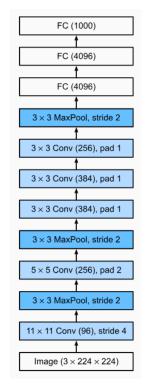

In [ ]:
image = Image.open("AlexNetarch.png")

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
net = nn.Sequential(

    # First convolutional layer:
    #3 input channels because we have coloured images
    #96 output channels, 11x11 kernel, stride of 4, padding of 1
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1),
    # Batch normalization to improve training stability
    # ReLU activation function
    nn.BatchNorm2d(96), nn.ReLU(),
    # Max pooling layer with 3x3 window and stride of 2
    nn.MaxPool2d(kernel_size=3, stride=2),

    # Second convolutional layer:
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.BatchNorm2d(256), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    #Third set of convolutional layers:
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.BatchNorm2d(384), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.BatchNorm2d(384), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    #Now we flatten the output for the fully connected layers
    nn.Flatten(),

    nn.Linear(6400, 4096), nn.ReLU(),
    #dropout layer for regularisation
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # the number of output classes is 5
    nn.Linear(4096, 5))

Now we are creating the datasets and the dataloader. Keep in mind that the **AlexNet** neural network takes as input images 224x224, since our images are 700x460 we have to resize them.

In [ ]:
transform2 = transforms.Compose([
    #image resizing
    transforms.Resize((224, 224)),
    #we are transforming the images in tensors
    transforms.ToTensor()
])

#dataloader definition
def get_dataloader_workers():
    """Use as many processes working in parallel to read the data as # CPU cores.
    Other recommended range: 2 to 4"""
    import os
    return os.cpu_count()

batch_size=32

#dataset creation
breast_train_dataset= datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/malignant/SOB',
                                           transform=transform2)
breast_test_dataset= datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/Test',
                                           transform=transform2)
#dataloader creation
#notice that we are performing the shuffle only for the train set
train_iter=data.DataLoader(breast_train_dataset, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())

test_iter=data.DataLoader(breast_test_dataset, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers())



In [ ]:
#here we assess if we the GPU is available in order to train the model
torch.cuda.is_available()

True

In the following PyTorch code, we are checking the shape of each layer by applying the *.shape* method to each layer of the Neural Network. Keep in mind that *.shape* returns the dimensions of a tensor.

In [ ]:
X = torch.randn(1, 3, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
BatchNorm2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
BatchNorm2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
BatchNorm2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
BatchNorm2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
BatchNorm2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape

# Training phase

Finally, we are training the model, we used a *learning rate* of 0.1 and we trained the model for 10 epochs. We chose these values in order to minimise the loss function in a limitated numer of epochs and to limit the loss function oscillation along the steps.

loss 0.967, train acc 0.632, test acc 0.626
589.7 examples/sec on cuda:0


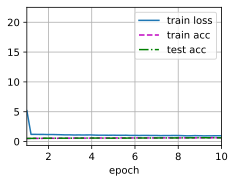

In [ ]:
lr, num_epochs = 0.1, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

We have that the model has train accuracy of 0.632 and test accuracy of 0.626, they are above 50%.

Now we are saving the parameters of the model in the file *'AlexNet_weights2.pth'*.

In [ ]:
torch.save(net, "AlexNet_weights2.pth")


In [ ]:
os.path.exists("AlexNet_weights2.pth")

True

In [ ]:
AlexNet_model2 = torch.load("/content/drive/MyDrive/AlexNet_weights2.pth", map_location=torch.device('cpu'))

In [ ]:
test_iter_DL = data.DataLoader(breast_test_dataset, batch_size, shuffle=True, num_workers= 2)

Now we want to compare the predictions with the true labels. So, the variable *y* contains all the correct labels and the variable *x* contains the correspondent images. The variable *pred* contains the predicted label associated to each image.

In [ ]:
for x, y in test_iter_DL:
  break
#x , y = x.cuda(), y.cuda()
pred = AlexNet_model2(x).argmax(axis=1)

First of all recall the association between the numeric labels with the actual ones.

In [ ]:
from IPython.display import display, Markdown
import pandas as pd


nomi = ['benign', 'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
numeri = [0, 1, 2, 3, 4]


tabella = pd.DataFrame(list(zip(numeri, nomi)), columns=['Num','Label'])


display(Markdown(tabella.to_markdown(index=False)))


|   Num |   Label             |
|------:|:--------------------|
|     0 | benign              |
|     1 | ductal_carcinoma    |
|     2 | lobular_carcinoma   |
|     3 | mucinous_carcinoma  |
|     4 | papillary_carcinoma |

# Prediction

In [ ]:
# make prediction
for x, y in (test_iter):
  break
x , y = x.cuda(), y.cuda()
pred = AlexNet_model2(x).argmax(axis=1)

<Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

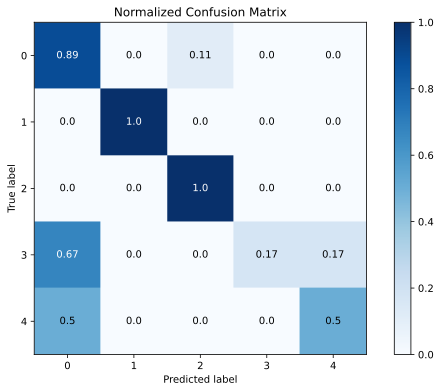

In [ ]:
skplt.metrics.plot_confusion_matrix(y.cpu(), pred.cpu(), normalize=True, cmap = 'Blues', figsize=(10,6))

From the matrix we can analyse the relative frequency of the images correctly classificated according to each label, we can observe this information on the main diagonal of the confusion matrix. The labels 0, 1 and 2 are well classificated by the model. The model has some issues in identifying the images that belong to the labels 3 and 4. In particular, the model misclassify the labels 3 and 4 with the label 0. This means that the model has some difficulties in identifying a particular type of tumor: *mucinous carcinoma*, the model classify it correctly only in the 17% of images.

Now we are plotting a couple of images displaying the predicted labels and the actual ones.

In [ ]:
# define a function to plot test images with real and predicted labels
def show(net, test_iter, n=6):

  # create two empy list for real and predicted labels
  titles = []
  pred_titles = []

  # define index j to access values in lists above
  j = 0

  # access iteratively data loader elements
  x_iter, y_iter = next(iter(test_iter))

  # move x_iter to cuda to make predictions
  x_iter = x_iter.cuda()
  # make prediction with g_model and find most probable class
  pred = net(x_iter).argmax(axis=1)

  # define a random index to plot images randomly
  random_idx = random.sample(range(32), n)

  # move back x_iter to cpu to allow comparisons
  x_iter = x_iter.cpu()


  for i in random_idx:
    # access single image and permute it to allow plotting
    img = x_iter[i].permute(1,2,0)

    # associate labels to indexes using ImageFolder classes
    for idx, label in enumerate(breast_test_dataset.classes):

      # check if the index stored in the y variable corresponds to the index of the ImageFolder class
      if y_iter[i] == idx:
        # if yes, appen the label which correspond to that index to the list
        titles.append(label)

      # same reasoning for the predicted classes
      if pred[i].cpu() == idx:
        pred_titles.append(label)

    # plot the image
    plt.imshow(img)
    # add title accessing j-th element in the list
    plt.title(f'True label: {titles[j]} \n Predict label: {pred_titles[j]}')
    # show image
    plt.show()

    # increment the counter to access following elements of the lists
    j+=1

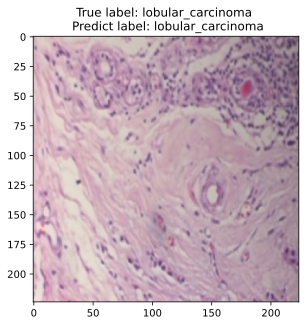

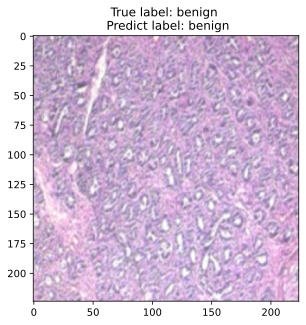

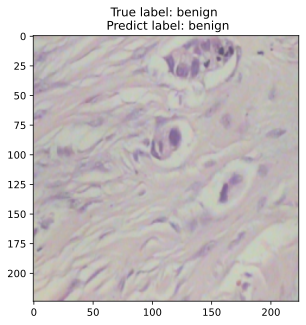

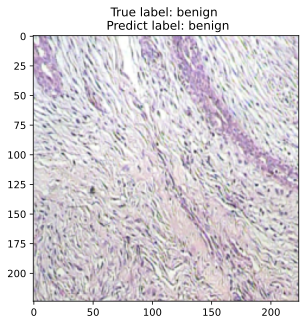

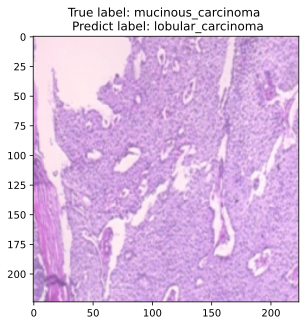

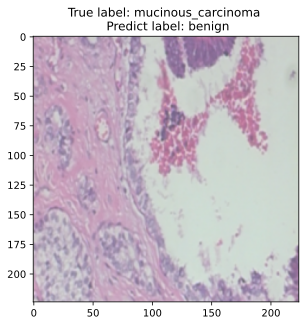

In [ ]:
# plot images
show(AlexNet_model2, test_iter_DL)